## Trying the module `healpix`

In [152]:
import healpix as hx
import healpy as hp

import random
import numpy as np

### Testing Functions

We need to make sure that we following functions, found in the sublib `toad.regridding.healpix`, are behaving the same in both modules:

- healpy.ang2pix()
	* line 36: hp.ang2pix(self.nside, lons, lats, lonlat=True)
- healpy.pix2ang()
	* line 40: hp.pix2ang(self.nside, pix)
    * line 221: hp.pix2ang(self.nside, pixels, lonlat=True)
- healpy.nside2npix()
	* lines 160, 217
- healpy.pixelfunc.get_min_valid_nside()
	* line 66	    
- healpy.mollview()
	* line 163

In [154]:
# helpy: `ang2pix` converts angular coordinates to pixel number
#       lonlat : bool
#               If True, input angles are assumed to be longitude and latitude in degree,
#               otherwise, they are co-latitude and longitude in radians.


sample = 100000

nside = 2000
lonlat = True

misses = 0
for i in range(sample):
    lon = random.uniform(-90, 90)
    lat = random.uniform(-180, 180)

    res_hp = hp.ang2pix(nside, lat, lon, lonlat=lonlat)
    res_hx = hx.ang2pix(nside, lat, lon, lonlat=lonlat)
    if res_hp != res_hx:
        misses += 1
        #print(f"Mismatch: {res_hp} != {res_hx}, for lat={lat}, lon={lon}")

print(f"Total misses for lat/lon random: {misses} out of {sample}")


misses = 0
for i in range(sample):
    lon = random.uniform(-90, 90)
    lat = 0#random.uniform(-180, 180)

    res_hp = hp.ang2pix(nside, lat, lon, lonlat=lonlat)
    res_hx = hx.ang2pix(nside, lat, lon, lonlat=lonlat)
    if res_hp != res_hx:
        misses += 1
        #print(f"Mismatch: {res_hp} != {res_hx}, for lat={lat}, lon={lon}")

print(f"Total misses for lon random, lat = 0: {misses} out of {sample}")

misses = 0
for i in range(sample):
    lon = 90#random.uniform(-90, 90)
    lat = random.uniform(-180, 180)

    res_hp = hp.ang2pix(nside, lat, lon, lonlat=lonlat)
    res_hx = hx.ang2pix(nside, lat, lon, lonlat=lonlat)
    if res_hp != res_hx:
        misses += 1
        #print(f"Mismatch: {res_hp} != {res_hx}, for lat={lat}, lon={lon}")

print(f"Total misses for lon = 90, lat random: {misses} out of {sample}")

Total misses for lat/lon random: 0 out of 100000
Total misses for lon random, lat = 0: 27032 out of 100000
Total misses for lon = 90, lat random: 100000 out of 100000


CONCLUSION: We can see here that the functions are behaving similar for most value pairs. Yet, at the boundaries they result in different pixel numbers. 

In [156]:
# healpy:`pix2ang` converts pixel number to angular coordinates
#       lonlat : bool, optional
#               If True, return angles will be longitude and latitude in degree,
#               otherwise, angles will be co-latitude and longitude in radians (default)

sample = 100000

nside = 2000
lonlat = False

misses = 0
for i in range(sample):
    pix = random.randint(0, 12*nside*nside-1)

    res_hp = np.array(hp.pix2ang(nside, pix, lonlat=lonlat))
    res_hx = np.array(hx.pix2ang(nside, pix, lonlat=lonlat))
    if res_hx[0] < 0 :
        res_hx[0] = res_hx[0] + 360
    if res_hx[1] < 0 :
        res_hx[1] = res_hx[1] + np.pi*2
    compare = np.allclose(res_hp, res_hx, rtol=1e-3)
    if not compare:
        misses += 1
        #print(f"Mismatch: {res_hp} != {res_hx}, for pix={pix}")

print(f"Total misses for lat/lon random: {misses} out of {sample}")


Total misses for lat/lon random: 0 out of 100000


CONCLUSION:<br>
We learned here that the two functions differe in the output in the following way:
- for lonlat = True, healpix.pix2ang returns lon in the range [-90,90]
- for lonlat=False, healpix.pix2ang returns lat in the range [-pi,pi]

## Exchanging in Library

In [1]:
# Prerequisites
import numpy as np
from toad import TOAD
from sklearn.cluster import HDBSCAN
from toad.regridding import HealPixRegridder as HealPixRegridder_hx
import matplotlib.pyplot as plt

from toad.regridding.healpix_old import HealPixRegridder

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 5)

# Dataset contains pre-computed shifts
td = TOAD("tutorials/test_data/global_mean_summer_tas.nc", log_level="INFO")
td.data = td.data.coarsen(lat=1, lon=1, boundary="trim").reduce(np.mean)

INFO: Logging level set to INFO


In [2]:
regridder = HealPixRegridder()

# So you don't need to pass it, but if you do, you can also plot clusters in the healpix grid, see 3 cells below.
td.compute_clusters(
    "tas",
    shifts_filter_func=lambda x: np.abs(x) > 0.5,
    method=HDBSCAN(min_cluster_size=10),
    overwrite=True,
    regridder=regridder,
)
# Take 3.0 on my laptop

print(f"Identified clusters: {td.get_cluster_ids('tas')}")
cluster_ids_hp = td.get_cluster_ids("tas")
cluster_hp = td.get_clusters("tas")

INFO: Automatically computed nside: 128
INFO: Applying clustering method HDBSCAN(min_cluster_size=10)


Identified clusters: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143]


In [3]:
regridder = HealPixRegridder_hx()

# So you don't need to pass it, but if you do, you can also plot clusters in the healpix grid, see 3 cells below.
td.compute_clusters(
    "tas",
    shifts_filter_func=lambda x: np.abs(x) > 0.5,
    method=HDBSCAN(min_cluster_size=10),
    overwrite=True,
    regridder=regridder,
)
# Take 3.0 on my laptop

print(f"Identified clusters: {td.get_cluster_ids('tas')}")
cluster_ids_hx = td.get_cluster_ids("tas")
cluster_hx = td.get_clusters("tas")

INFO: Automatically computed nside: 128
INFO: Applying clustering method HDBSCAN(min_cluster_size=10)


Identified clusters: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143]


In [4]:
# compare cluster ids
compare_ids = np.array_equal(cluster_ids_hp, cluster_ids_hx)
print(f"Cluster ids match: {compare_ids}")

compare_clusters = np.array_equal(cluster_hp, cluster_hx)
print(f"Clusters match: {compare_clusters}")

Cluster ids match: True
Clusters match: True


In [7]:
# Prerequisites
import numpy as np
from toad import TOAD
from sklearn.cluster import HDBSCAN
from toad.regridding import HealPixRegridder as HealPixRegridder_hx
import matplotlib.pyplot as plt

from toad.regridding.healpix_old import HealPixRegridder

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 5)

# Dataset contains pre-computed shifts
td = TOAD("tutorials/test_data/garbe_2020_antarctica.nc", log_level="INFO")
td.data = td.data.coarsen(x=10, y=10, boundary="trim").reduce(np.mean)

INFO: Logging level set to INFO


In [9]:
print(td.data)

<xarray.Dataset> Size: 1MB
Dimensions:  (time: 350, y: 19, x: 19)
Coordinates:
  * time     (time) int64 3kB 301 701 1101 1501 ... 138701 139101 139501 139901
  * x        (x) float64 152B -2.888e+06 -2.568e+06 ... 2.552e+06 2.872e+06
  * y        (y) float64 152B -2.888e+06 -2.568e+06 ... 2.552e+06 2.872e+06
    lat      (y, x) float64 3kB -53.63 -55.47 -57.2 ... -57.39 -55.66 -53.81
    lon      (y, x) float64 3kB -135.0 -138.4 -142.1 -146.3 ... 37.85 41.62 45.0
Data variables:
    thk      (time, y, x) float32 505kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    thk_dts  (time, y, x) float32 505kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes: (12/13)
    CDI:            Climate Data Interface version 1.9.6 (http://mpimet.mpg.d...
    proj4:          +lon_0=0.0 +ellps=WGS84 +datum=WGS84 +lat_ts=-71.0 +proj=...
    CDO:            Climate Data Operators version 1.9.6 (http://mpimet.mpg.d...
    source:         PISM (development v1.0-535-gb3de48787 committed by Julius...
    institu

In [ ]:
regridder = HealPixRegridder()

# So you don't need to pass it, but if you do, you can also plot clusters in the healpix grid, see 3 cells below.
td.compute_clusters(
    "thk",
    shifts_filter_func=lambda x: np.abs(x) > 0.5,
    method=HDBSCAN(min_cluster_size=10),
    overwrite=True,
    #regridder=regridder,
)
# Take 3.0 on my laptop

print(f"Identified clusters: {td.get_cluster_ids('thk')}")
cluster_ids_hp = td.get_cluster_ids("thk")
cluster_hp = td.get_clusters("thk")

INFO: Automatically computed nside: 8


ValueError: THETA is out of range [0,pi]

## Regridding Sandbox

In [11]:
data = xr.open_dataset("tutorials/test_data/garbe_2020_antarctica.nc")

# lower the resolution to speed up computation
data = data.coarsen(x=2, y=2, time=2, boundary="trim").reduce(np.mean)

NameError: name 'xr' is not defined

In [ ]:
from toad import TOAD

# Init the TOAD object with an xarray or .nc file
td = TOAD(data)

/tmp/ipykernel_20098/4168011674.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


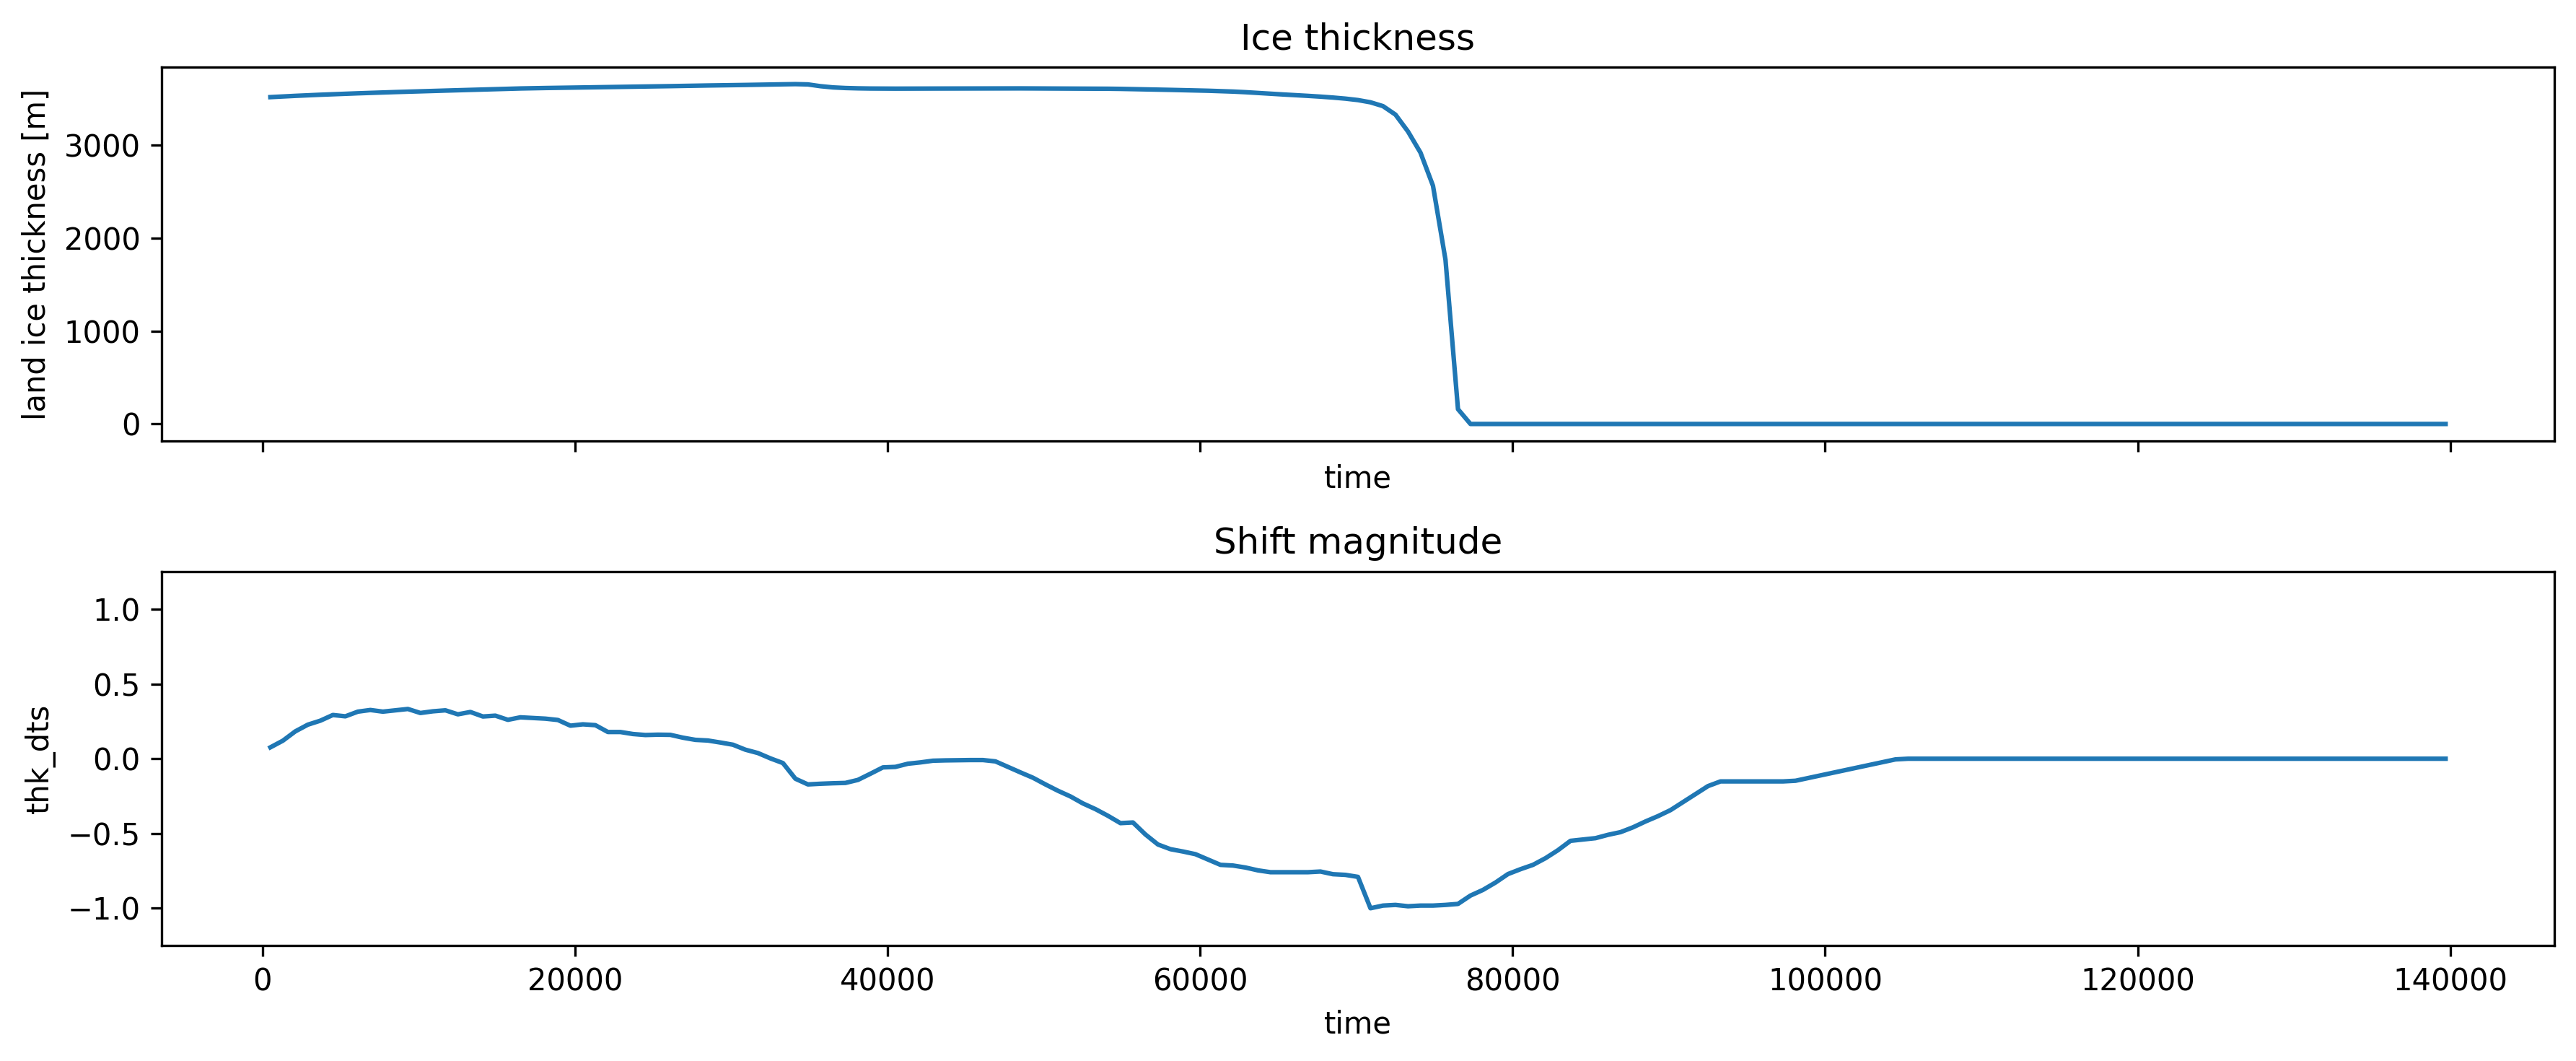

In [4]:
from toad.shifts_detection.methods import ASDETECT

td.compute_shifts("thk", method=ASDETECT())

fig, axs = plt.subplots(2, sharex=True)
idx, idy = 75, 39
td.data.thk.isel(x=idx, y=idy).plot(ax=axs[0])
td.data.thk_dts.isel(x=idx, y=idy).plot(ax=axs[1])
axs[0].set_title("Ice thickness")
axs[1].set_title("Shift magnitude")
axs[1].set_ylim(-1.25, 1.25)
fig.tight_layout()
fig.show()

In [5]:
from sklearn.cluster import HDBSCAN  # type: ignore

# Minimum required input is a variable name and a method. For HDBSCAN we also need a filtering function.
td.compute_clusters(
    var="thk",  # toad will find computed shifts for this variable
    method=HDBSCAN(min_cluster_size=10),
    shifts_filter_func=lambda x: np.abs(x) > 0.9,
)

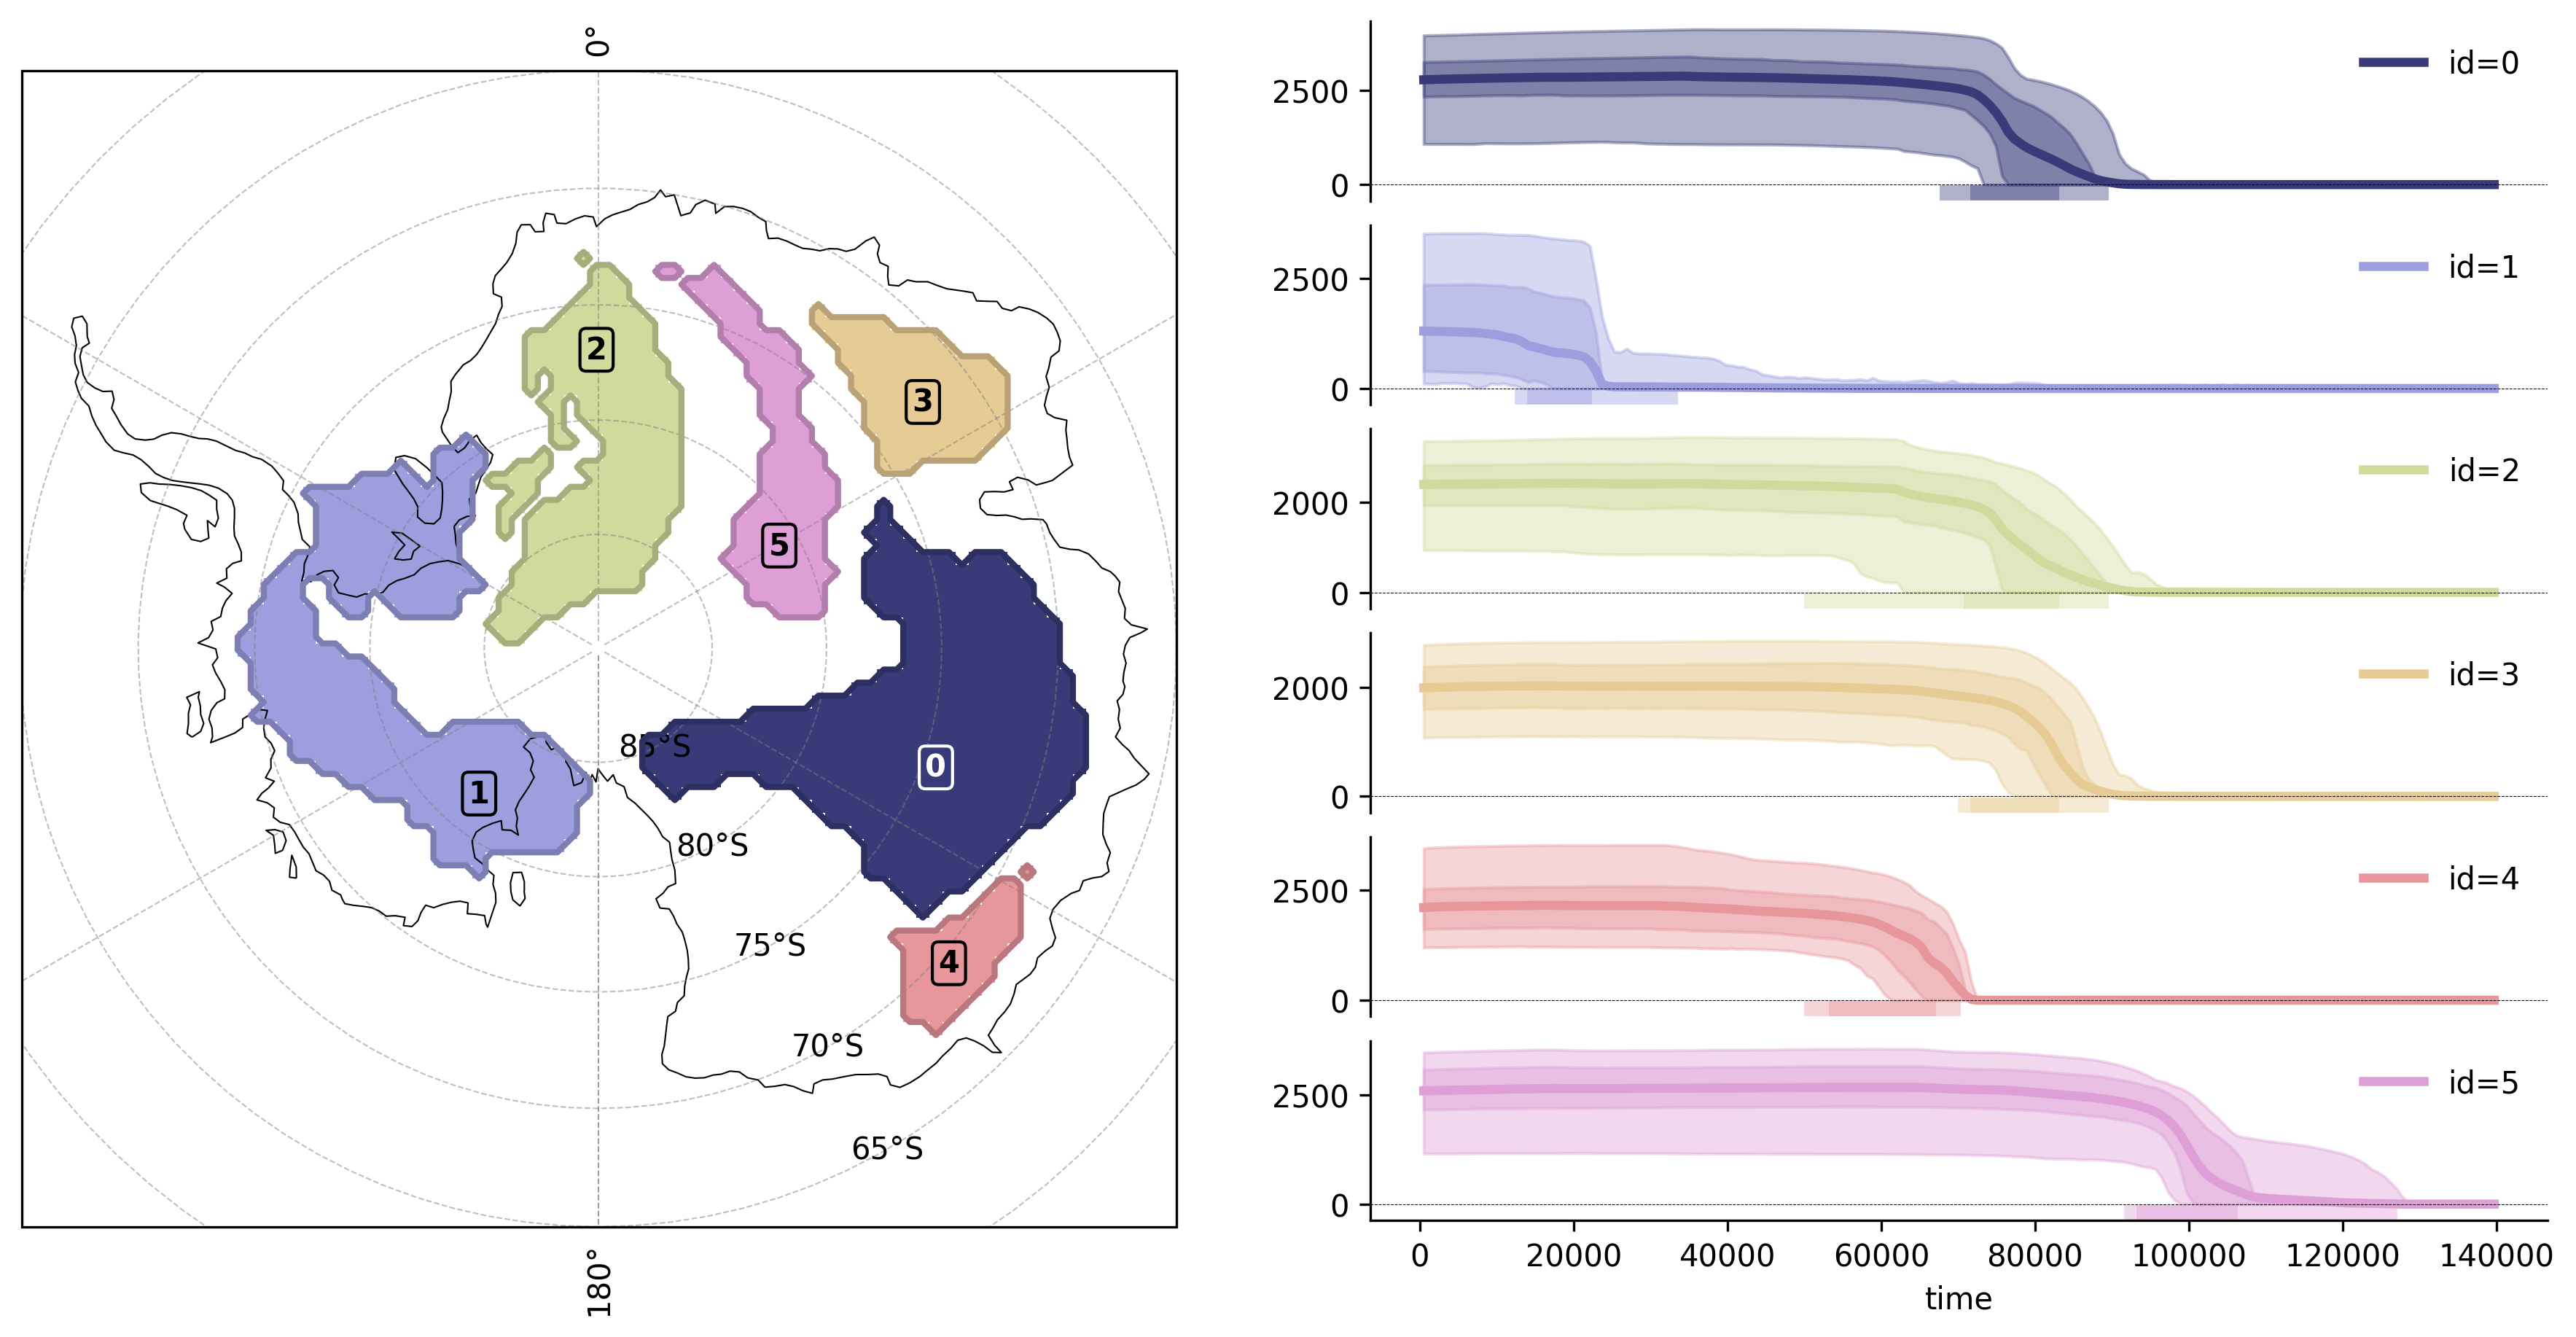

In [6]:
td.plotter().cluster_overview(
    "thk",
    cluster_ids=range(6),  # plot the 6 largest clusters
    projection="south_pole",
);